In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson, cumulative_trapezoid
from imripy import constants as c, kepler, merger_system as ms, halo, inspiral, plot_utils as pu, waveform, detector
from imripy.inspiral import forces
from imripy.kepler import KeplerOrbit
import plotting
import copy
import common

This notebook explores dry inspirals, that means a central MBH with a stellar distribution and the associated stellar diffusion. Also adds a DM spike around it.
It explores the phase space flow of $(a,e)$, shows an example inspiral, and calculates the dephasing and deshifting.

In [2]:
# Example System
m1 = 1e5 * c.solar_mass_to_pc
m2 = 10. * c.solar_mass_to_pc
D_l = 5e8 # 50 Mpc

hs = ms.HostSystem(m1, D_l=D_l)

In [3]:
from collections.abc import Sequence
issequence = lambda x: isinstance(x, Sequence)

# Dry Inspirals

## Phase Space Flow

In [4]:
# GW loss
gw = inspiral.forces.GWLoss()
# Stellar Distribution
stellarHalo, stellarDiffusion = common.StellarDistributionAna(hs, E_m_s=m2)

# DM spikes
spike_73, df_73 = common.DMSpike(hs, 7./3.)
spike_32, df_32 = common.DMSpike(hs, 3./2.)

In [5]:
opt_gw_sd = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion])

opt_gw_sd_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, df_32])

opt_gw_sd_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, df_73])

(1.356537180701499e-06, 205.78196928780687)
(1.3584221896200073e-06, 205.78196929088583)
(1.3699537278668664e-06, 205.79689963795497)


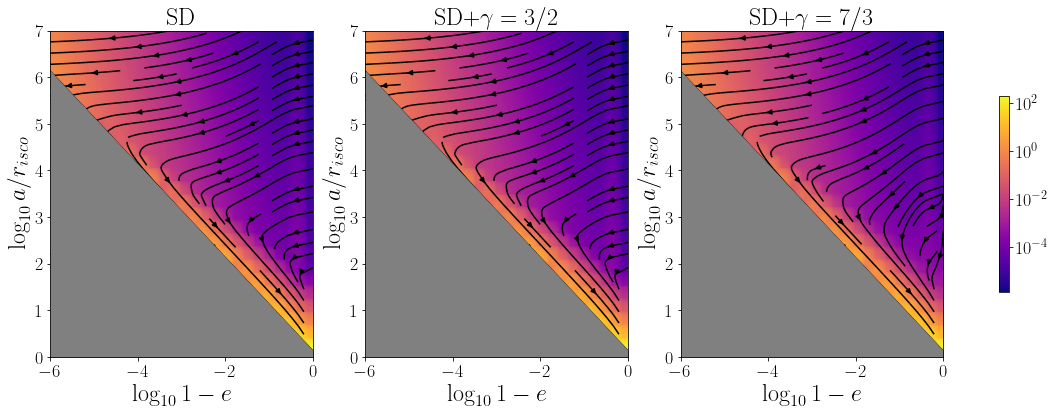

In [20]:
fig,axs = plt.subplots(1,3, figsize=(20,6))
a_grid = np.geomspace(hs.r_isco, 1e7*hs.r_isco, 25)
e_grid = 1.- np.geomspace(1e-6, 1., 25)

ko = KeplerOrbit(hs, m2, 0.)

im = pu.streamline(axs[0], hs, opt_gw_sd, ko, a_grid, e_grid)
axs[0].set_title(r"SD")
print(im.get_clim())

im = pu.streamline(axs[1], hs, opt_gw_sd_32, ko, a_grid, e_grid)
axs[1].set_title(r"SD+$\gamma=3/2$")
print(im.get_clim())

im = pu.streamline(axs[2], hs, opt_gw_sd_73, ko, a_grid, e_grid)
axs[2].set_title(r"SD+$\gamma=7/3$")
print(im.get_clim())

fig.colorbar(im, ax=axs, shrink=0.6)

for ax in axs:
    ax.set_xlabel(r"$\log_{10} 1-e$"); ax.set_ylabel(r"$\log_{10} a/r_{isco}$"); ax.set_xlim(right=0)
fig.savefig("plots/psf_dry.pdf", bbox_inches="tight")

### Example

In [7]:
a0 = 1e4 * hs.r_isco
e0 = 0.9  # eccentric
k0 = kepler.KeplerOrbit(hs, m2, a0, e0)

In [8]:
t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2

k = 0.34
sigma = np.sqrt(m1 / (1.+ stellarHalo.alpha) / a0)
t_AM =  ( 2*k*sigma**3 / (stellarHalo.density(a0)/stellarDiffusion.E_m_s)
          / stellarDiffusion.E_m_s**2 / stellarDiffusion.CoulombLogarithm * (1.-e0))
print(t_GW, t_AM)

78551331808.54974 45500.00576064258


In [9]:
opt_sd = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion],
                                              periapsePrecession=True, accuracy=1e-9)
hs.halo = stellarHalo
ev_sd = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*np.min([t_AM, t_GW]), opt=opt_sd)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, }, accuracy = 1.0e-09, with periapse precession
A termination event occurred.
 -> Ended at 2.743e+00r_isco. Evolution took 903.8819s real time


In [10]:
opt_sd_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, df_32],
                                                    periapsePrecession=True, accuracy=1e-9)

hs.halo = halo.CombinedHalo([stellarHalo, spike_32])
ev_sd_32 = inspiral.Classic.Evolve(hs, k0, t_fin = ev_sd.t[-1], opt=opt_sd_32)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-09, with periapse precession
A termination event occurred.
 -> Ended at 2.743e+00r_isco. Evolution took 1077.8097s real time


In [11]:
opt_sd_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, df_73],
                                                    periapsePrecession=True, accuracy=1e-9)

hs.halo = halo.CombinedHalo([stellarHalo, spike_73])
ev_sd_73 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*ev_sd.t[-1], opt=opt_sd_73)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-09, with periapse precession
A termination event occurred.
 -> Ended at 2.717e+00r_isco. Evolution took 966.9956s real time


In [12]:
ev_sd.f = np.sqrt(ev_sd.m_tot/ev_sd.a**3) / 2. / np.pi
ev_sd_32.f = np.sqrt(ev_sd_32.m_tot/ev_sd_32.a**3) / 2. / np.pi
ev_sd_73.f = np.sqrt(ev_sd_73.m_tot/ev_sd_73.a**3) / 2. / np.pi

ev_sd.N = cumulative_trapezoid(ev_sd.f, ev_sd.t, initial=0)
ev_sd_32.N = cumulative_trapezoid(ev_sd_32.f, ev_sd_32.t, initial=0)
ev_sd_73.N = cumulative_trapezoid(ev_sd_73.f, ev_sd_73.t, initial=0)

<ipython-input-41-69aaf7ff274e>:43: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f53b014c7c0> starts with '_'. It is thus excluded from the legend.
  axs[1,1].legend(["_","_","_", "$n_b=4/3$"])
<ipython-input-41-69aaf7ff274e>:43: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f53b014cfa0> starts with '_'. It is thus excluded from the legend.
  axs[1,1].legend(["_","_","_", "$n_b=4/3$"])
<ipython-input-41-69aaf7ff274e>:43: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f53b0158730> starts with '_'. It is thus excluded from the legend.
  axs[1,1].legend(["_","_","_", "$n_b=4/3$"])


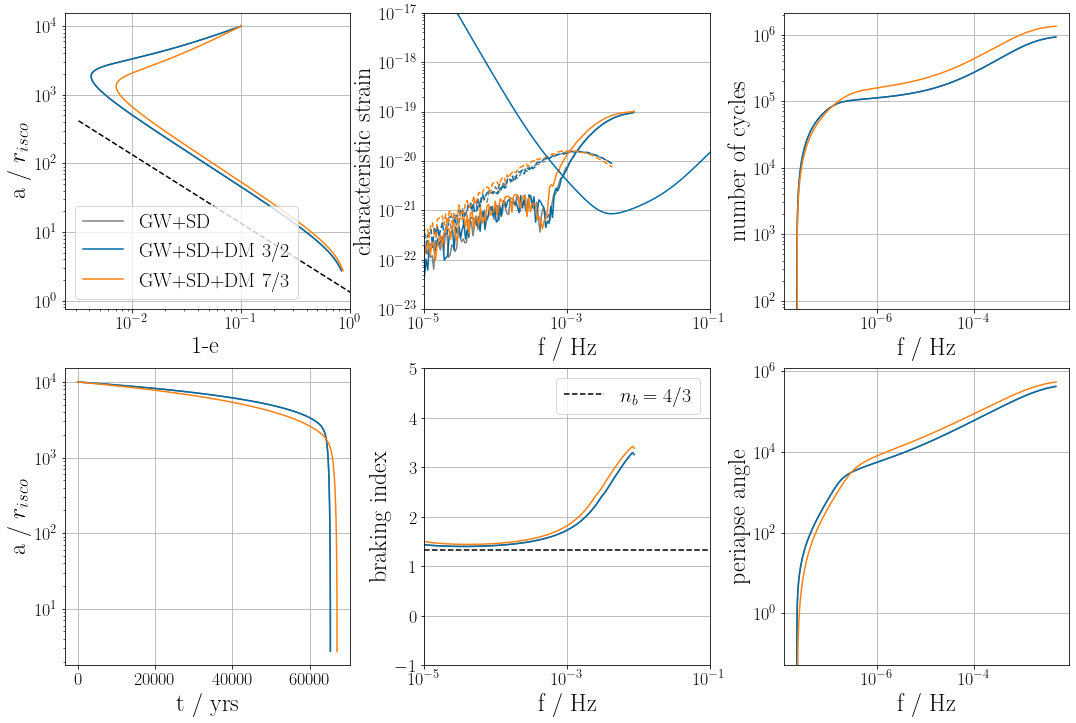

In [41]:
fig, axs = plt.subplots(2,3, figsize=(18,12))

l0=pu.plotEvolution(hs, ev_sd, ax_1mea=axs[0,0], ax_a=axs[1,0], ax_n=axs[1,1], color='gray', label='GW+SD')
#pu.plotEvolution(hs, ev_gw_sec, ax_1mea=axs[0,0], ax_a=axs[1,0], ax_n=axs[1,1], label='GW')
l1=pu.plotEvolution(hs, ev_sd_32, ax_1mea=axs[0,0], ax_a=axs[1,0], ax_n=axs[1,1], label='GW+SD+DM 3/2')
l2=pu.plotEvolution(hs, ev_sd_73, ax_1mea=axs[0,0], ax_a=axs[1,0], ax_n=axs[1,1], label='GW+SD+DM 7/3')

pu.plotGWcharacteristicStrain(hs, ev_sd, axs[0,1], harmonics=[2,1], color=l0.get_c())
axs[0,2].loglog(ev_sd.f / c.hz_to_invpc, ev_sd.N, color=l0.get_c())
axs[1,2].loglog(ev_sd.f / c.hz_to_invpc, ev_sd.periapse_angle, color=l0.get_c())

pu.plotGWcharacteristicStrain(hs, ev_sd_32, axs[0,1], harmonics=[2,1], color=l1.get_c())
axs[0,2].loglog(ev_sd_32.f / c.hz_to_invpc, ev_sd_32.N, color=l1.get_c())
axs[1,2].loglog(ev_sd_32.f / c.hz_to_invpc, ev_sd_32.periapse_angle, color=l1.get_c())


pu.plotGWcharacteristicStrain(hs, ev_sd_73, axs[0,1], harmonics=[2,1], color=l2.get_c())
axs[0,2].loglog(ev_sd_73.f / c.hz_to_invpc, ev_sd_73.N, color=l2.get_c())
axs[1,2].loglog(ev_sd_73.f / c.hz_to_invpc, ev_sd_73.periapse_angle, color=l2.get_c())


e_grid = 1.-np.array(axs[0,0].get_xlim())
axs[0,0].plot(1.-e_grid, 8./6./(1.-e_grid), linestyle='--', color='black'); axs[0,0].legend(loc='lower left'); 

axs[0,0].set_xlim(right=1.); axs[0,0].set_xlabel("1-e"); axs[0,0].set_ylabel("a / $r_{isco}$")

f_gw = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
axs[0,1].loglog(f_gw/c.hz_to_invpc, detector.Lisa().NoiseStrain(f_gw), label='LISA')
axs[0,1].set_xlabel("f / Hz"); axs[0,1].set_ylabel("characteristic strain")
axs[0,1].set_xlim(left=1e-5, right=1e-1); axs[0,1].set_ylim(bottom=1e-23, top=1e-17)


axs[1,0].set_xlabel("t / yrs")
axs[1,0].set_ylabel("a / $r_{isco}$")
axs[1,0].set_xscale('linear')

axs[1,1].set_xlabel("f / Hz")
axs[1,1].set_ylabel("braking index")
axs[1,1].set_ylim(-1, 5)
axs[1,1].set_xlim(axs[0,1].get_xlim())
axs[1,1].set_xscale('log')
axs[1,1].axhline(4./3., linestyle='--', color='black'); 
axs[1,1].legend(["_","_","_", "$n_b=4/3$"])

axs[0,2].set_xlabel("f / Hz")
axs[0,2].set_ylabel("number of cycles")

axs[1,2].set_xlabel("f / Hz")
axs[1,2].set_ylabel("periapse angle")

for ax in axs.flatten():
    ax.grid()
fig.subplots_adjust(wspace=0.26)
fig.savefig(f"plots/ev_dry_{m1/c.solar_mass_to_pc:.1e}.pdf", bbox_inches="tight")

In [14]:
dE_df_32 = common.energy_loss(hs, ev_sd_32, df_32, opt_sd_32)
r_df_32 = dE_df_32 / spike_32.potentialEnergy(spike_32.r_spike)
print(dE_df_32, r_df_32) # feedback ratio

-3.6065058795800227e-22 8.785858727929212e-05


In [15]:
dE_df_73 = common.energy_loss(hs, ev_sd_73, df_73, opt_sd_73)
r_df_73 = dE_df_73 / spike_73.potentialEnergy(spike_73.r_spike)
print(dE_df_73, r_df_73)

-1.1829036556817086e-16 0.04237900967168039


## Dephasing and Deshifting

In [21]:
def timescales(hs, k0, stellarDiffusion):
    a0 = k0.a; e0 = k0.e; m1=hs.m1; m2=k0.m2; stellarHalo = stellarDiffusion.stellarDistribution
    t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2

    k = 0.34
    sigma = np.sqrt(m1 / (1.+ stellarHalo.alpha) / a0)
    t_AM =  ( 2*k*sigma**3 / (stellarHalo.density(a0)/stellarDiffusion.E_m_s)
          / stellarDiffusion.E_m_s**2 / stellarDiffusion.CoulombLogarithm * (1.-e0))
    return t_GW, t_AM

In [22]:
def calc_dephasing(hss, df_base, df_compare, k0s, opts, hs_base=None, k0_base=None, opt_base=None, n=2):
    if not issequence(hss):
        hss = [copy.deepcopy(hss) for i in range(len(df_compare))]  # careful to make actual copies and not references
    if not issequence(k0s):
        k0s = [copy.deepcopy(k0s) for i in range(len(df_compare))]
    if not issequence(opts):
        opts = [copy.deepcopy(opts) for i in range(len(df_compare))]
    
    hs_base = hs_base or copy.deepcopy(hss[0])
    k0_base = k0_base or copy.deepcopy(k0s[0])
    opt_base = opt_base or copy.deepcopy(opts[0])
    #opt_base.dissipativeForces = df_base
    
    for i, dfs in enumerate(df_compare):
        opts[i].dissipativeForces = df_base + dfs
    
    ts = np.array(timescales(hs_base, k0_base, df_base[1]))
    print(ts)
    ev_base = inspiral.Classic.Evolve(hs_base, k0_base, t_fin=1e2*np.min(ts), opt=opt_base)
    ev_base.f_gw, ev_base.N = waveform.N_cycles_n(2, hs_base, ev_base)
    _, ev_base.h_2p, ev_base.h_2c, __ = waveform.h_n(2, hs_base, ev_base)
    ev_base.f_orbit, ev_base.h_1p, ev_base.h_1c, __ = waveform.h_n(1, hs_base, ev_base)
    N_0interp = interp1d(ev_base.f_gw, ev_base.N, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    pa_base = interp1d(ev_base.f_gw, ev_base.periapse_angle - ev_base.periapse_angle[-1], kind='cubic',
                           bounds_error=False, fill_value=(0.,0.))

    evs = [ev_base]
    for i,(hs, k0, opt) in enumerate(zip(hss, k0s, opts)):
        ts = list(timescales(hs, k0, df_base[1])); ts.append(ev_base.t[-1])
        print(i, ts)
        ev = inspiral.Classic.Evolve(hs, k0, t_fin=1e2*np.min(ts), opt=opt)
        ev.f_gw, ev.N = waveform.N_cycles_n(2, hs, ev)
        ev.dN = ev.N - N_0interp(ev.f_gw)
        _, ev.h_2p, ev.h_2c, __ = waveform.h_n(2, hs, ev)
        ev.f_orbit, ev.h_1p, ev.h_1c, __ = waveform.h_n(1, hs, ev)
        ev.dpa = np.abs((ev.periapse_angle - ev.periapse_angle[-1]) - pa_base(ev.f_gw))
        evs.append(ev)
    return evs

In [35]:
def compare_different_m1(m1, m2, D_l, acc=1e-10):
    hs_base = ms.HostSystem(m1, D_l=D_l)
    # GW loss
    #environmental effects
    gw = inspiral.forces.GWLoss()
    stellarHalo, stellarDiffusion = common.StellarDistributionAna(hs_base, E_m_s=m2)
    #dmDisk, gdf_dm = common.AccretionDisk(hs_base)
    spike_73, df_73 = common.DMSpike(hs_base, 7./3.)
    spike_32, df_32 = common.DMSpike(hs_base, 3./2.)
    
    # base
    df_base = [gw, stellarDiffusion]
    opt_base = inspiral.Classic.EvolutionOptions(dissipativeForces=copy.deepcopy(df_base), periapsePrecession=True, accuracy=acc)
    # different hs for different mass precession
    hs_base.halo = stellarHalo
    hs_32 = copy.deepcopy(hs_base); hs_73 = copy.deepcopy(hs_base); 
    hs_32.halo = halo.CombinedHalo([stellarHalo, spike_32]); hs_73.halo = halo.CombinedHalo([stellarHalo, spike_73])
    # initial orbit
    a0 = 1e4 * hs_base.r_isco
    e0 = 0.9
    k0_base = kepler.KeplerOrbit(hs_base, m2, a0, e0)
    # calc dephasing
    evs = calc_dephasing([hs_32, hs_73], df_base, [[df_32], [df_73]], k0s=k0_base, opts=opt_base, hs_base=hs_base)
    # feedback ratio
    evs[1].r_df = common.energy_loss(evs[1].hs, evs[1], evs[1].options.dissipativeForces[-1], evs[1].options) / spike_32.potentialEnergy(spike_32.r_spike)
    evs[2].r_df = common.energy_loss(evs[2].hs, evs[2], evs[2].options.dissipativeForces[-1], evs[2].options) / spike_73.potentialEnergy(spike_73.r_spike)
    
    return evs

In [36]:
evs_dry_m1e5 = compare_different_m1(1e5*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)
evs_dry_m1e5[0].save("runs/evs_dry_m1e5_m2e1_0.npz")
evs_dry_m1e5[1].save("runs/evs_dry_m1e5_m2e1_1.npz")
evs_dry_m1e5[2].save("runs/evs_dry_m1e5_m2e1_2.npz")

[7.85513318e+10 4.55000058e+04]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended at 2.743e+00r_isco. Evolution took 1757.7196s real time
0 [78551331808.54974, 45500.00576064258, 20016.1168675631]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended at 2.743e+00r_isco. Evolution took 1902.4673s real time
1 [78551331808.54974, 45500.00576064258, 20016.1168675631]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended at 2

In [37]:
evs_dry_m1e4 = compare_different_m1(1e4*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)
evs_dry_m1e4[0].save("runs/evs_dry_m1e4_m2e1_0.npz")
evs_dry_m1e4[1].save("runs/evs_dry_m1e4_m2e1_1.npz")
evs_dry_m1e4[2].save("runs/evs_dry_m1e4_m2e1_2.npz")

[7.85513318e+08 2.10981846e+03]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended at 2.681e+00r_isco. Evolution took 1567.2682s real time
0 [785513318.0854973, 2109.8184634888444, 922.5333577800177]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended at 2.681e+00r_isco. Evolution took 1721.9682s real time
1 [785513318.0854973, 2109.8184634888444, 922.5333577800177]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended 

In [38]:
evs_dry_m1e3 = compare_different_m1(1e3*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)
evs_dry_m1e3[0].save("runs/evs_dry_m1e3_m2e1_0.npz")
evs_dry_m1e3[1].save("runs/evs_dry_m1e3_m2e1_1.npz")
evs_dry_m1e3[2].save("runs/evs_dry_m1e3_m2e1_2.npz")

[7.85513318e+06 1.14784598e+02]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended at 2.669e+00r_isco. Evolution took 1204.5882s real time
0 [7855133.180854973, 114.78459840574881, 49.40548008317495]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended at 2.669e+00r_isco. Evolution took 1356.8704s real time
1 [7855133.180854973, 114.78459840574881, 49.40548008317495]
Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.9  with  Options: dissipative forces employed {GWLoss, Stellar Diffusion2*, DynamicalFriction, }, accuracy = 1.0e-10, with periapse precession
A termination event occurred.
 -> Ended 

In [ ]:
evs_dry_m2e1 = compare_different_m1(1e5*c.solar_mass_to_pc, 1e1*c.solar_mass_to_pc, 5e8)
evs_dry_m2e1[0].save("runs/evs_dry_m2e1_0.npz")
evs_dry_m2e1[1].save("runs/evs_dry_m2e1_1.npz")
evs_dry_m2e1[2].save("runs/evs_dry_m2e1_2.npz")

In [ ]:
''' 
hs_m1e3 = ms.HostSystem(1e3*c.solar_mass_to_pc, D_l=D_l)
evs_dry_m1e3 = [inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e3_0.npz", hs_m1e3, opt_sd),
               inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e3_1.npz", hs_m1e3, opt_sd_32),
               inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e3_2.npz", hs_m1e3, opt_sd_73)]
hs_m1e4 = ms.HostSystem(1e4*c.solar_mass_to_pc, D_l=D_l)
evs_dry_m1e4 = [inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e4_0.npz", hs_m1e4, opt_sd),
               inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e4_1.npz", hs_m1e4, opt_sd_32),
               inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e4_2.npz", hs_m1e4, opt_sd_73)]
hs_m1e5 = ms.HostSystem(1e5*c.solar_mass_to_pc, D_l=D_l)
evs_dry_m1e5 = [inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e5_0.npz", hs_m1e5, opt_gw_sd),
               inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e5_1.npz", hs_m1e5, opt_gw_sd_32),
               inspiral.Classic.EvolutionResults.load("runs/evs_dry_m1e5_2.npz", hs_m1e5, opt_gw_sd_73)]
'''

In [ ]:
def recompute_from_loaded(evs):
    evs[0].f_gw, evs[0].N = waveform.N_cycles_n(2, evs[0].hs, evs[0])
    _, evs[0].h_2p, evs[0].h_2c, __ = waveform.h_n(2, evs[0].hs, evs[0])
    #ev_base.f_orbit, ev_base.h_1p, ev_base.h_1c, __ = waveform.h_n(1, hs_base, ev_base)
    N_0interp = interp1d(evs[0].f_gw, evs[0].N, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    pa_base = interp1d(evs[0].f_gw, evs[0].periapse_angle - evs[0].periapse_angle[-1], kind='cubic',
                           bounds_error=False, fill_value=(0.,0.))

    for i in range(1,len(evs)):
        evs[i].f_gw, evs[i].N = waveform.N_cycles_n(2, evs[i].hs, evs[i])
        evs[i].dN = evs[i].N - N_0interp(evs[i].f_gw)
        _, evs[i].h_2p, evs[i].h_2c, __ = waveform.h_n(2, evs[i].hs, evs[i])
        #evs[i].f_orbit, ev.h_1p, ev.h_1c, __ = waveform.h_n(1, hs, evs[i])
        evs[i].dpa = np.abs((evs[i].periapse_angle - evs[i].periapse_angle[-1]) - pa_base(evs[i].f_gw))
        evs[i].r_df = ( common.energy_loss(evs[i].hs, evs[i], evs[i].options.dissipativeForces[-1], evs[i].options) 
                    / (spike_32.potentialEnergy(spike_32.r_spike) if i == 1 else spike_73.potentialEnergy(spike_73.r_spike)) )
    

#recompute_from_loaded(evs_dry_m1e3)
#recompute_from_loaded(evs_dry_m1e4)
#recompute_from_loaded(evs_dry_m1e5)

In [31]:
def plot_observable_dephasing(ax, evs, labels, ax_di=None, min_dN=1.):
    Lisa = detector.Lisa()
    bw = Lisa.Bandwith()
    
    for i, ev in enumerate(evs):
        observable = ( (ev.f_gw > bw[0]) &  (ev.f_gw < bw[1]) & 
                                  (2.*ev.f_gw*ev.h_2p > Lisa.NoiseStrain(ev.f_gw)))[:-1]
        
        nobservable = np.where(np.logical_not(observable))[0]
        observable = np.where(observable)[0]
        
        if np.any(nobservable[1:] != (nobservable[:-1]+1)): # there is a gap
            lgap = np.argmax(nobservable[1:] != (nobservable[:-1]+1))
            rgap = len(nobservable)-1- np.argmax(nobservable[::-1][1:] != (nobservable[::-1][:-1]-1))
            l, = ax.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[:lgap]]), 
                        linestyle= '--')
            l, = ax.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
        else:
            l, = ax.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.dN[nobservable]), 
                        linestyle= '--')
            
        l, = ax.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.dN[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
        print(labels[i], ev.r_df)
        l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax, color=l.get_c(), marker='p',
                                            y=interp1d(ev.f_gw, np.abs(ev.dN)))
        
        if ax_di is not None:
            ddN_df = np.gradient(ev.dN, ev.f_gw)
            stop = np.where(np.abs(ev.dN) < min_dN)[0]
            stop = stop[0] if len(stop) > 0 else len(ddN_df)
            ax_di.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddN_df/ev.dN * ev.f_gw)[:stop], color=l.get_c())
        

$m_1=10^5M_\odot, \gamma=3/2$ 8.78587166497721e-05
$m_1=10^5M_\odot, \gamma=7/3$ 0.04237957360111564
$m_1=10^4M_\odot, \gamma=3/2$ 0.0016129870278859153
$m_1=10^4M_\odot, \gamma=7/3$ 1.1155333526103293
$m_1=10^3M_\odot, \gamma=3/2$ 0.03190608077703296
$m_1=10^3M_\odot, \gamma=7/3$ 27.755295231180163


<ipython-input-31-63025c67ce62>:33: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddN_df/ev.dN * ev.f_gw)[:stop], color=l.get_c())


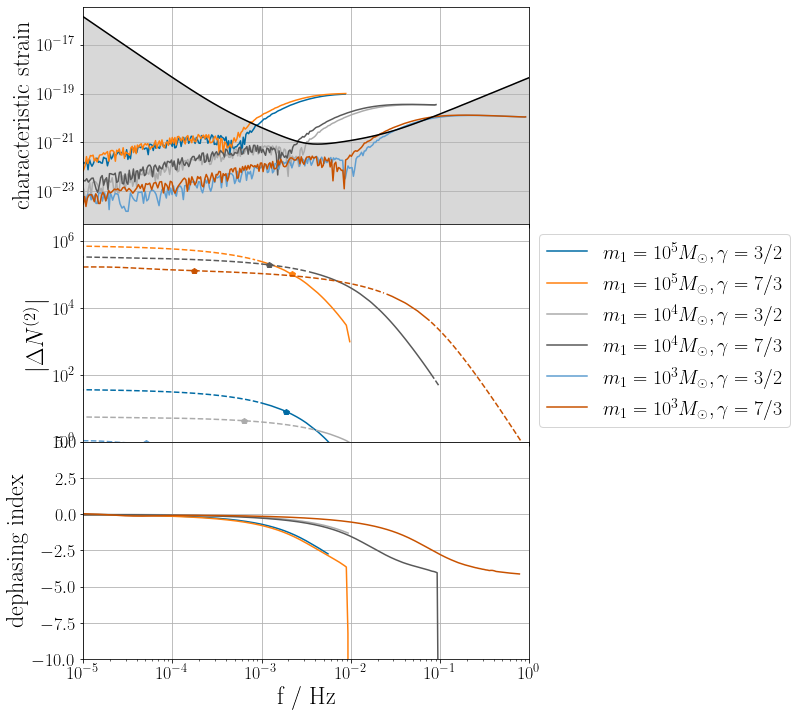

In [42]:
fig, axs = plt.subplots(3,1, sharex='all', figsize=(8,12))
Lisa = detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
for ev in evs_dry_m1e5[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_dry_m1e4[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_dry_m1e3[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])

axs[0].loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA', color='black')
axs[0].fill_between(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), color='gray', alpha=0.3)
    
plot_observable_dephasing(axs[1], evs_dry_m1e5[1:], ["$m_1=10^5M_\odot, \gamma=3/2$", "$m_1=10^5M_\odot, \gamma=7/3$"],
                             ax_di=axs[2])
plot_observable_dephasing(axs[1], evs_dry_m1e4[1:], ["$m_1=10^4M_\odot, \gamma=3/2$", "$m_1=10^4M_\odot, \gamma=7/3$"],
                             ax_di=axs[2])
plot_observable_dephasing(axs[1], evs_dry_m1e3[1:], ["$m_1=10^3M_\odot, \gamma=3/2$", "$m_1=10^3M_\odot, \gamma=7/3$"],
                             ax_di=axs[2])
for ax in axs:
    ax.grid()
axs[1].legend(bbox_to_anchor=(1.,1.), loc='upper left')
axs[1].set_ylim(bottom=1.); axs[1].set_xlim(left=1e-5, right=1)
axs[1].set_ylabel("$|\Delta N^{(2)}|$")
axs[0].set_ylabel("characteristic strain")

axs[2].set_xlabel("f / Hz")
axs[2].set_ylim(-10, 5)
axs[2].set_ylabel("dephasing index")

fig.subplots_adjust(hspace=0.)
fig.savefig(f"plots/dephasing_dry.pdf", bbox_inches="tight")

In [33]:
def plot_observable_deshifting(ax_d, evs, labels, ax_w = None, ax_ds=None, min_w=1.):
    Lisa = detector.Lisa()
    bw = Lisa.Bandwith()
    
    for i, ev in enumerate(evs):
        observable = ( (ev.f_gw > bw[0]) &  (ev.f_gw < bw[1]) & 
                                  (2.*ev.f_gw*ev.h_2p > Lisa.NoiseStrain(ev.f_gw)))[:-1]
        
        nobservable = np.where(np.logical_not(observable))[0]
        observable = np.where(observable)[0]
        
        if np.any(nobservable[1:] != (nobservable[:-1]+1)): # there is a gap
            lgap = np.argmax(nobservable[1:] != (nobservable[:-1]+1))
            rgap = len(nobservable)- np.argmax(nobservable[::-1][1:] != (nobservable[::-1][:-1]-1))
            l, = ax_d.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.dpa[nobservable[:lgap]]), 
                        linestyle= '--')
            l, = ax_d.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.dpa[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
            if not ax_w is None:
                ax_w.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.periapse_angle[nobservable[:lgap]]), 
                        linestyle= '--')
                ax_w.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.periapse_angle[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
        else:
            l, = ax_d.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.dpa[nobservable]), 
                        linestyle= '--')
            if not ax_w is None:
                ax_w.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.periapse_angle[nobservable]), 
                        linestyle= '--')
        
        l, = ax_d.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.dpa[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
        l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax_d, color=l.get_c(), marker='p', 
                                     y=interp1d(ev.f_gw, np.abs(ev.dpa)))
        
        if not ax_w is None:
            ax_w.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.periapse_angle[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
            l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax_w, color=l.get_c(), marker='p', 
                                     y=interp1d(ev.f_gw, np.abs(ev.periapse_angle)))
        if ax_ds is not None:
            ddpa_df = np.gradient(ev.dpa, ev.f_gw)
            stop = np.where(np.abs(ev.dpa) < min_w)[0]
            stop = stop[0] if len(stop) > 0 else len(ddpa_df)
            ax_ds.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddpa_df/ev.dpa * ev.f_gw)[:stop], color=l.get_c())

<ipython-input-33-005cb3c2f23b>:45: RuntimeWarning: divide by zero encountered in divide
  ax_ds.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddpa_df/ev.dpa * ev.f_gw)[:stop], color=l.get_c())


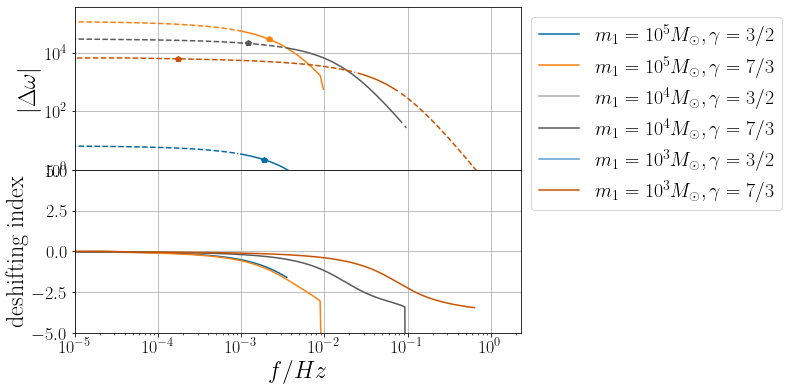

In [44]:
fig, axs = plt.subplots(2,1, sharex='all', figsize=(8,6))
plot_observable_deshifting(axs[0], evs_dry_m1e5[1:], ["$m_1=10^5M_\odot, \gamma=3/2$", "$m_1=10^5M_\odot, \gamma=7/3$"], 
                             ax_ds=axs[1])
plot_observable_deshifting(axs[0], evs_dry_m1e4[1:], ["$m_1=10^4M_\odot, \gamma=3/2$", "$m_1=10^4M_\odot, \gamma=7/3$"], 
                               ax_ds=axs[1])
plot_observable_deshifting(axs[0], evs_dry_m1e3[1:], ["$m_1=10^3M_\odot, \gamma=3/2$", "$m_1=10^3M_\odot, \gamma=7/3$"], 
                              ax_ds=axs[1])

for ax in axs:
    ax.grid()
    ax.set_ylim(bottom=1); ax.set_xlim(left=1e-5)

axs[1].set_xlabel("$f / Hz$")
#axs[0].set_ylabel("$\omega$")
axs[0].set_ylabel("$|\Delta \omega|$")
axs[0].legend(bbox_to_anchor=(1.,1.), loc='upper left') 
axs[1].set_ylim(-5, 5)
axs[1].set_ylabel("deshifting index")

fig.subplots_adjust(hspace=0.)
fig.savefig(f"plots/deshifting_dry.pdf", bbox_inches="tight")